# Problem Statement and Domain
The problem presented is the is in the domain of health and medical practice where digitized images of a fine needle aspirate of a breast mass are examined for cancer. The diagnosis of the mass is malignant or benign. The diagnosis helps doctors find breast cancer in early stages and can improve the chances of survival of a patient if intervention is made early. This is necessary as it curbs the spread of the cancer cells to other parts of the body. In addition to the benefits of early detection, using machine learning and artificial intelligence for breast cancer detection is racially unbiased compared to traditional models

In [1]:
# Import all necessary modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import sklearn.model_selection
%matplotlib inline 

In [2]:
# sagemaker libraries
import boto3
import sagemaker

# Dataset input
The dataset is obtained from https://www.kaggle.com/uciml/breast-cancer-wisconsin-data which was originally created by Bennett, Kristin P., and Olvi L. Mangasarian. "Robust linear programming discrimination of two linearly inseparable sets." Optimization methods and software 1, no. 1 (1992): 23-34.
The attribute information are as follows: 1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32) Ten real-valued features are computed for each cell nucleus.
Class distribution: 357 benign, 212 malignant

In [3]:
# Load the data and perform exploratory analysis
df = pd.read_csv('data.csv', header = 0, index_col = 0)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


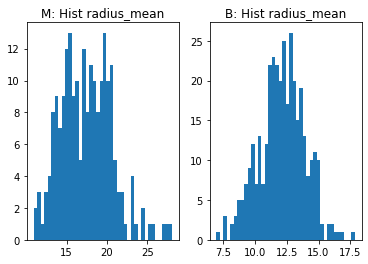

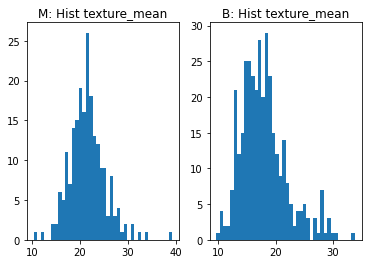

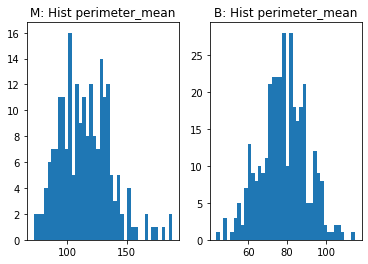

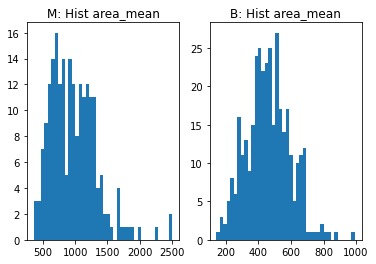

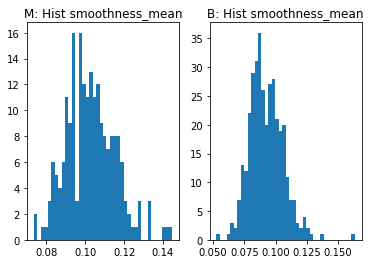

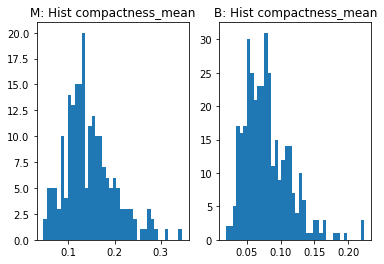

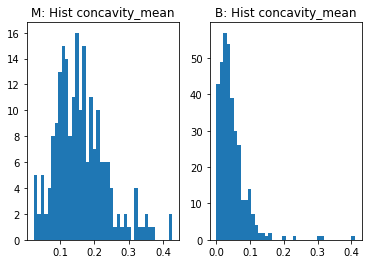

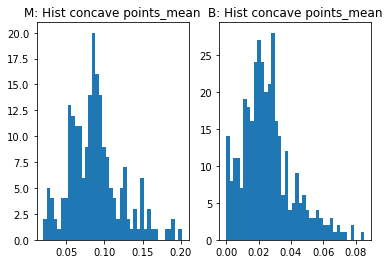

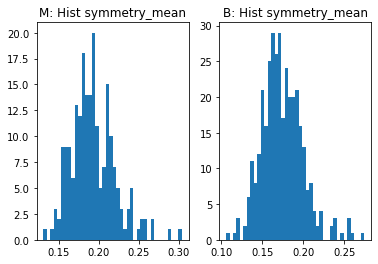

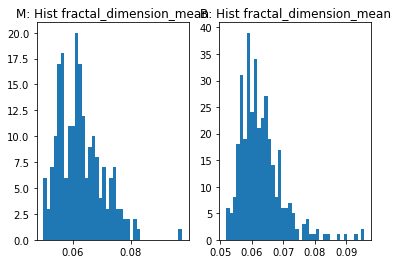

In [4]:
# Attributes 
attribute_list = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
n_bins = 40

for column_name in attribute_list:
    fig,(ax1, ax2) =plt.subplots(1,2)
    # get data by column_name and display a histogram
    ax1.hist(df.loc[df['diagnosis'] == 'M', column_name], bins=n_bins)
    ax2.hist(df.loc[df['diagnosis'] == 'B', column_name], bins=n_bins)
    ax1.set_title( "M: Hist " + column_name)
    ax2.set_title( "B: Hist " + column_name)

**Exploratory Data Analysis** The plots above show that a fair distinction between malignant and benign features. Chief of them being histconcave_points, radius and perimeter.
A casual observation shows that a Linear classifier may do a pretty good job. However we will implement a Neural Network here in PyTorch and possibly a Support Vector Machine for comparison

In [5]:
from sagemaker import get_execution_role
session =sagemaker.Session()
# store the current SageMaker session
# get IAM role
role=get_execution_role()
print(role)

bucket_name=session.default_bucket()
print(bucket_name)

#define prefix and output path
prefix='mamogram'
output_path='s3://{}/{}/'.format(bucket_name,prefix)

arn:aws:iam::172268057478:role/service-role/AmazonSageMaker-ExecutionRole-20210122T150167
sagemaker-us-east-1-172268057478


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler  = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:,1:]), columns=df.iloc[:,1:].columns)

# Dimensionality Reduction
Given that we have many features present in this dataset, it is beneficial to reduce the number of features we will pass to our classifier.
To do this, the principal component analysis from amazon sagemaker would be implemented as follows

In [71]:
from sagemaker import PCA

session = sagemaker.Session()

N_COMPONENTS = df_scaled.shape[1] - 1 # I used -2 here previously as i was having nr components error, check again
pca_SM = PCA(role = role, 
             train_instance_count = 1,
             train_instance_type = 'ml.c4.xlarge', 
             output_path = output_path, 
             num_components = N_COMPONENTS, 
             sagemaker_session = session )

print(N_COMPONENTS)

train_data_np = df.iloc[:,1:].values.astype('float32')
formatted_train_data = pca_SM.record_set( train_data_np )



train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


29


In [72]:
#Train the PCA model
%time
# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
2021-03-14 23:26:00 Starting - Starting the training job...
2021-03-14 23:26:23 Starting - Launching requested ML instancesProfilerReport-1615764360: InProgress
......
2021-03-14 23:27:27 Starting - Preparing the instances for training.........
2021-03-14 23:28:56 Downloading - Downloading input data
2021-03-14 23:28:56 Training - Downloading the training image...
2021-03-14 23:29:30 Uploading - Uploading generated training model
2021-03-14 23:29:30 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/14/2021 23:29:20 INFO 139835981031232] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist

In [78]:
training_job_name='pca-2021-03-14-23-26-00-015' 
model_key=os.path.join(prefix,training_job_name,'output/model.tar.gz')

print(model_key)
# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key,'model.tar.gz')
# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

mamogram/pca-2021-03-14-23-26-00-015/output/model.tar.gz


2304

# Select Nr of components to retain using explained variance
We will select a number of components that retain at least 85% of the explained variance in the original data

In [79]:
import mxnet as mx
# loading the unzipped artifacts
pca_model_params=mx.ndarray.load('model_algo-1')

# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())

In [80]:
def explained_variance(s , n_top_components ):
    '''Calculates the approx. data variance that n_top_components captures.
    :param s: A dataframe of singular values for top components;
    the top value is in the last row.
    :param n_top_components: An integer, the number of top components to use.
    :return: The expected data variance covered by the n_top_components.'''
    start_idx = N_COMPONENTS - n_top_components
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    return exp_variance[0]

In [81]:
# test cell
#print(s)
n_top_components = N_COMPONENTS//2
# select a set of values for the number of top components and examing the corresponding explained variance
# calculate the explained variance


print('----------------------------------------\n')
print('n_top_component   ', 'Explained variance: ')
for top_component in range(1,n_top_components):
    exp_variance = explained_variance ( s , top_component )
    print ( ' %-14d     %-9.6f %%' %(top_component, exp_variance*100 ) )


----------------------------------------

n_top_component    Explained variance: 
 1                  98.204499 %
 2                  99.822116 %
 3                  99.977863 %
 4                  99.989957 %
 5                  99.998790 %
 6                  99.999452 %
 7                  99.999857 %
 8                  99.999928 %
 9                  99.999970 %
 10                 99.999988 %
 11                 99.999994 %
 12                 100.000000 %
 13                 100.000000 %


**Nr of components to choose** : The analysis above shows that we can get away with 5-6 features and yet retain a huge percentage of the variance in the orginial dataset

In [82]:
# Deploy the pca
%time
pca_predictor = pca_SM.deploy(initial_instance_count=1,instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
-----------------!

In [83]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)

In [84]:
# create dimensionality-reduced data
def create_transformed_df( train_pca , df_scaled , n_top_components ):
    ''' Return a dataframe of data points with component features.
    The dataframe should be indexed by id and contain component values.
    :param train_pca: A list of pca training data, returned by a PCA model.
    :param df_scaled: A dataframe of normalized, original features.
    :param n_top_components: An integer, the number of top components to use.
    :return: A dataframe, indexed by id, with n_top_component values as columns.
    '''
    # create new dataframe to add data to
    df_transformed = pd.DataFrame()
    # for each of our new, transformed data points # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components = data.label['projection'].float32_tensor.values
        df_transformed = df_transformed.append([list(components)])
    
    df_transformed.index=df_scaled.index # index by id as in the previous dataframe
    
    # keep only the top n components
    start_idx = N_COMPONENTS-n_top_components
    df_transformed=df_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order
    return df_transformed.iloc[:, ::-1]

In [85]:
# specify top n
top_n = 5
# call your function and create a new dataframe
df_transformed = create_transformed_df(train_pca, df_scaled, n_top_components = top_n)

# rename columns
PCA_list = ['c_1','c_2','c_3','c_4','c_5']

df_transformed.columns = PCA_list

# print result
df_transformed.head()

,c_1,c_2,c_3,c_4,c_5
0,1160.142456,-293.917755,48.578362,8.711304,-32.000587
1,1269.122437,15.630157,-35.394497,-17.861328,4.335159
2,995.793823,39.156708,-1.709747,-4.199310,0.466625
3,-407.180725,-67.380241,8.672813,11.759758,-7.115633
4,930.341309,189.340622,1.374796,-8.499107,-7.613194


# Prepare the data for training
We will use 6 features from the reduced dimensionality produced by the PCA
Split the data into test train : 67% : 33%
Store the training and test data in csv and upload to s3


In [86]:
dict_category = {'B':0, 'M':1}
target = df.iloc[:,0].apply(lambda x : dict_category[x]) # convert the class into 0-1 Binary and store the target class 
X_train,X_test,Y_train,Y_test = sklearn.model_selection.train_test_split(df_transformed, target,test_size=0.3)

In [87]:
df_transformed.head()

,c_1,c_2,c_3,c_4,c_5
0,1160.142456,-293.917755,48.578362,8.711304,-32.000587
1,1269.122437,15.630157,-35.394497,-17.861328,4.335159
2,995.793823,39.156708,-1.709747,-4.199310,0.466625
3,-407.180725,-67.380241,8.672813,11.759758,-7.115633
4,930.341309,189.340622,1.374796,-8.499107,-7.613194


In [88]:
target.head()

id
842302      1
842517      1
84300903    1
84348301    1
84358402    1
Name: diagnosis, dtype: int64

In [89]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../Capstone Project/data/'
if not os.path.exists( data_dir ):
    os.makedirs(data_dir)

In [90]:
# create the training and test data and save locally
#pd.concat([pd.DataFrame(Y_test),pd.DataFrame(X_test)],axis=1).to_csv(os.path.join(data_dir,'test.csv'),header=False,index=False)
#pd.concat([pd.DataFrame(Y_train),pd.DataFrame(X_train)],axis=1).to_csv(os.path.join(data_dir,'train.csv'),header=False,index=False) 

#print(np.reshape(Y_test.values, (Y_test.shape[0], 1)).shape)
#print(X_test.values.shape)
test = np.hstack([np.reshape(Y_test.values, (Y_test.shape[0], 1)), X_test.values])
train = np.hstack([np.reshape(Y_train.values, (Y_train.shape[0], 1)), X_train.values])
pd.DataFrame(test).to_csv(os.path.join(data_dir,'test.csv'),header=False,index=False)
pd.DataFrame(train).to_csv(os.path.join(data_dir,'train.csv'),header=False,index=False)

In [91]:
# set prefix, a descriptive name for a directory for our train test data
prefix = 'cancer-class'
# upload all data to S3
test_location = session.upload_data(os.path.join(data_dir,'test.csv'),key_prefix=prefix)
train_location= session.upload_data(os.path.join(data_dir,'train.csv'),key_prefix=prefix)

In [92]:
# Create correlation matrix for just Features to determine different models to test
corr_matrix = df_transformed.corr().abs().round(2)

# display shows all of a dataframe
display(corr_matrix)

,c_1,c_2,c_3,c_4,c_5
c_1,1.0,0.0,0.0,0.0,0.0
c_2,0.0,1.0,0.0,0.0,0.0
c_3,0.0,0.0,1.0,0.0,0.0
c_4,0.0,0.0,0.0,1.0,0.0
c_5,0.0,0.0,0.0,0.0,1.0
